from: https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py

In [1]:
from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

Using TensorFlow backend.


In [2]:
# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

In [3]:
 #util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [4]:
# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

model.summary()


Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0      

In [5]:
# this is the placeholder for the input images
input_img = model.input


In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7fd71d9487b8>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7fd70f807208>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7fd70f814ac8>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7fd70f7baf98>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7fd70f75d6a0>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7fd70f76feb8>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7fd70f77ef60>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7fd70f78fbe0>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7fd70f72fcc0>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7fd70f73f588>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7fd70f6e04e0>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7fd70f6f0c18>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7fd70f701be0>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7fd70f6a255

In [7]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [8]:
kept_filters = []
for filter_index in range(0, 200):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))


Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

In [9]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]


In [10]:
# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

In [13]:
# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
#imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)


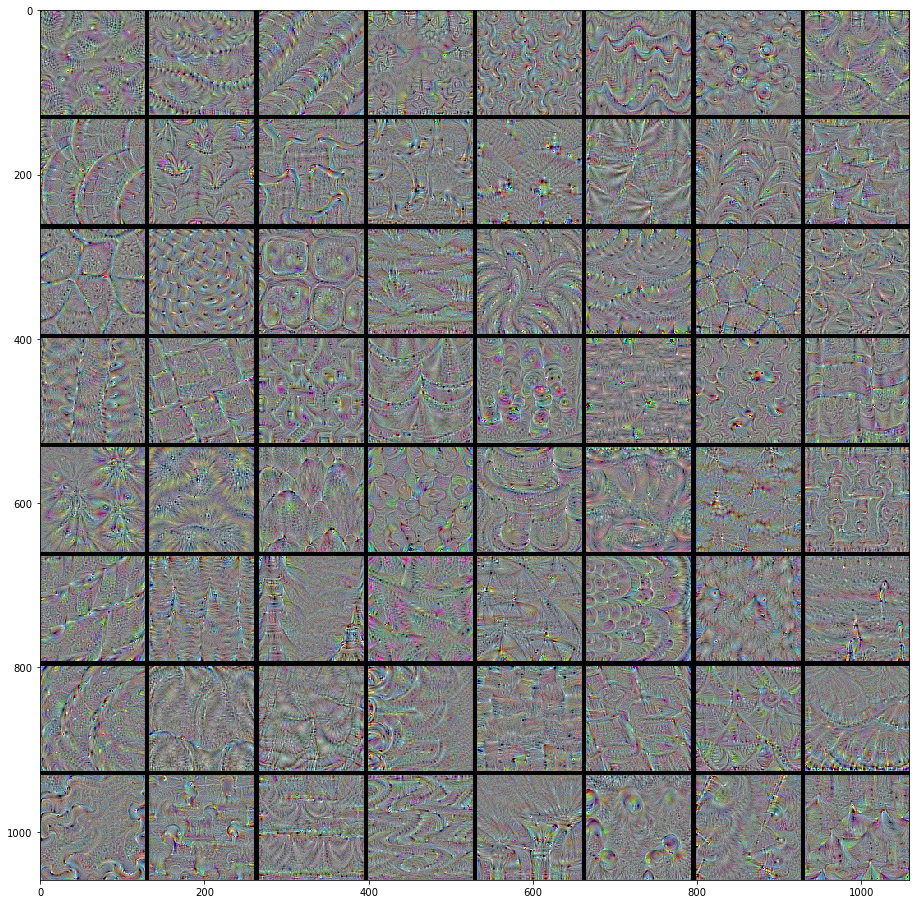

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,16]
plt.imshow(stitched_filters)